<a href="https://colab.research.google.com/github/pachterlab/voyager/blob/documentation/vignettes/visium_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages
Google Colab provides a mostly fresh machine, where we need to install the dependencies. However, some packages, such as the Tidyverse, are pre-installed. First install system dependencies of `sf`

In [3]:
system("apt-get -y update && apt-get install -y  libudunits2-dev libgdal-dev libgeos-dev libproj-dev")

These are system dependencies of some other R packages that `Voyager` either imports or suggests.

In [5]:
system("apt-get install -y libfribidi-dev libcairo2-dev libmagick++-dev")

As of writing, Voyager is on Bioconductor devel

In [2]:
install.packages("BiocManager")
BiocManager::install(version = "devel", ask = FALSE, update = FALSE, Ncpus = 2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Installing package(s) 'BiocVersion'



Some packages used in the vignette are not used in the package itself, and hence are suggested rather than imported, and `dependencies = TRUE` installs all the suggested package. This takes a while.

In [14]:
BiocManager::install("Voyager", dependencies = TRUE, Ncpus = 2, update = FALSE)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Installing package(s) 'Voyager'

also installing the dependencies ‘SpatialExperiment’, ‘SpatialFeatureExperiment’, ‘scater’




In [15]:
packageVersion("Voyager")

[1] ‘0.99.7’

# Introduction

In this introductory vignette for [`SpatialFeatureExperiment`](https://bioconductor.org/packages/devel/bioc/html/SpatialFeatureExperiment.html) data representation and [`Voyager`](https://bioconductor.org/packages/devel/bioc/html/Voyager.html) anlaysis package, we demonstrate a basic exploratory data analysis (EDA) of spatial transcriptomics data. Basic knowledge of R and [`SingleCellExperiment`](https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html) is assumed.

This vignette showcases the packages with a Visium spatial gene expression system dataset. The technology was chosen due to its popularity, and therefore the availability of numerous publicly available datasets for analysis [@Moses2022-xz].

![](https://pachterlab.github.io/LP_2021/04-current_files/figure-html/n-insts-1.png)

While Voyager was developed with the goal of facilitating the use of geospatial methods in spatial genomics, this introductory vignette is restricted to non-spatial scRNA-seq EDA with the Visium dataset. For a vignette illustrating univariate spatial analysis with the same dataset, see the more advanced [exploratory spatial data analyis vignette](https://pachterlab.github.io/voyager/articles/vig2_visium.htil) with the same dataset.

Here we load the packages used in this vignette.

In [18]:
library(Voyager)
library(SpatialFeatureExperiment)
library(SingleCellExperiment)
library(SpatialExperiment)
library(scater)
library(scran)
library(patchwork)
library(bluster)
library(SFEData)
library(BiocParallel)
library(stringr)
library(ggplot2)
library(sparseMatrixStats)
theme_set(theme_bw(10))

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

# Mouse skeletal muscle dataset
The dataset used in this vignette is from the paper [Large-scale integration of single-cell transcriptomic data captures transitional progenitor states in mouse skeletal muscle regeneration](https://doi.org/10.1038/s42003-021-02810-x) [@McKellar2021-ek]. Notexin was injected into the tibialis anterior muscle of mice to induce injury, and the healing muscle was collected 2, 5, and 7 days post injury for Visium analysis. The dataset in this vignette is from the timepoint at day 2. The vignette starts with a `SpatialFeatureExperiment` (SFE) object.

The gene count matrix was directly downloaded [from GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4904759). All 4992 spots, whether in tissue or not, are included. The tissue boundary was found by thresholding the H&E image in OpenCV, and small polygons were removed as they are likely to be debris. Spot polygons were constructed with the spot centroid coordinates and diameter in the Space Ranger output. The `in_tissue` column in `colData` indicates which spot polygons intersect the tissue polygons, and is based on `st_intersects()`. 

Tissue boundary, nuclei, myofiber, and Visium spot polygons are stored as `sf` data frames in the SFE object. The Visium spot polygons are called "spotPoly" in this SFE object. The `SpatialFeatureExperiment` package has a few convenience wrappers to get and set common types of geometries, including `spotPoly()` for Visium (or other technologies when relevant) spot polygons, `cellSeg()` for cell segmentation, `nucSeg()` for nuclei segmentation, and `centroids()` for cell centroids. Behind the scene are specially named `sf` data frames. See [the vignette of `SpatialFeatureExperiment`](https://bioconductor.org/packages/devel/bioc/vignettes/SpatialFeatureExperiment/inst/doc/SFE.html) for more details on the structure of the SFE object. 

The SFE object of this dataset is provided in the `SFEData` package; we begin by downloading the data and loading it into R.

In [19]:
(sfe <- McKellarMuscleData("full"))

snapshotDate(): 2022-10-24

see ?SFEData and browseVignettes('SFEData') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache



class: SpatialFeatureExperiment 
dim: 15123 4992 
metadata(0):
assays(1): counts
rownames(15123): ENSMUSG00000025902 ENSMUSG00000096126 ...
  ENSMUSG00000064368 ENSMUSG00000064370
rowData names(6): Ensembl symbol ... vars cv2
colnames(4992): AAACAACGAATAGTTC AAACAAGTATCTCCCA ... TTGTTTGTATTACACG
  TTGTTTGTGTAAATTC
colData names(12): barcode col ... prop_mito in_tissue
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : imageX imageY
imgData names(1): sample_id

Geometries:
colGeometries: spotPoly (POLYGON) 
annotGeometries: tissueBoundary (POLYGON), myofiber_full (POLYGON), myofiber_simplified (POLYGON), nuclei (POLYGON), nuclei_centroid (POINT) 

Graphs:
Vis5A: 

The authors provided the full resolution hematoxylin and eosin (H&E) image on GEO, which we downsized to facilitate its display:

![](https://github.com/pachterlab/voyager/raw/documentation/vignettes/tissue_lowres_5a.jpeg)

# Quality control
## Spots
We begin quality control (QC) by plotting various metrics both as violin plots and in space. The QC metrics are pre-computed and stored in `colData` (for spots) and `rowData` of the SFE object.

In [20]:
names(colData(sfe))

[1] "barcode"   "col"       "row"       "x"         "y"         "dia"      
 [7] "tissue"    "sample_id" "nCounts"   "nGenes"    "prop_mito" "in_tissue"

Below we plot the total unique molecular identifier (UMI) counts per spot. The commented out line of code shows how to compute the total UMI counts.

In [47]:
# Set plot size in jupyter
options(repr.plot.width=12, repr.plot.height=8)
theme_font <- theme(axis.text=element_text(size=16), #change font size of axis text
        axis.title=element_text(size=20), #change font size of axis titles
        plot.title=element_text(size=24), #change font size of plot title
        legend.text=element_text(size=16), #change font size of legend text
        legend.title=element_text(size=20))
theme_font_void <- theme(axis.text=element_blank(), #change font size of axis text
        axis.title=element_blank(), #change font size of axis titles
        plot.title=element_text(size=24), #change font size of plot title
        legend.text=element_text(size=16), #change font size of legend text
        legend.title=element_text(size=20))
theme_set(theme_bw() + theme_font)

In [35]:
plot_violin_spatial <- function(sfe, feature) {
  violin <- plotColData(sfe, feature, x = "in_tissue", colour_by = "in_tissue") +
    theme(legend.position = "top") + theme_font
  spatial <- plotSpatialFeature(sfe, feature, colGeometryName = "spotPoly",
                                annotGeometryName = "tissueBoundary") +
                                theme_void() + theme_font_void
  violin + spatial
}

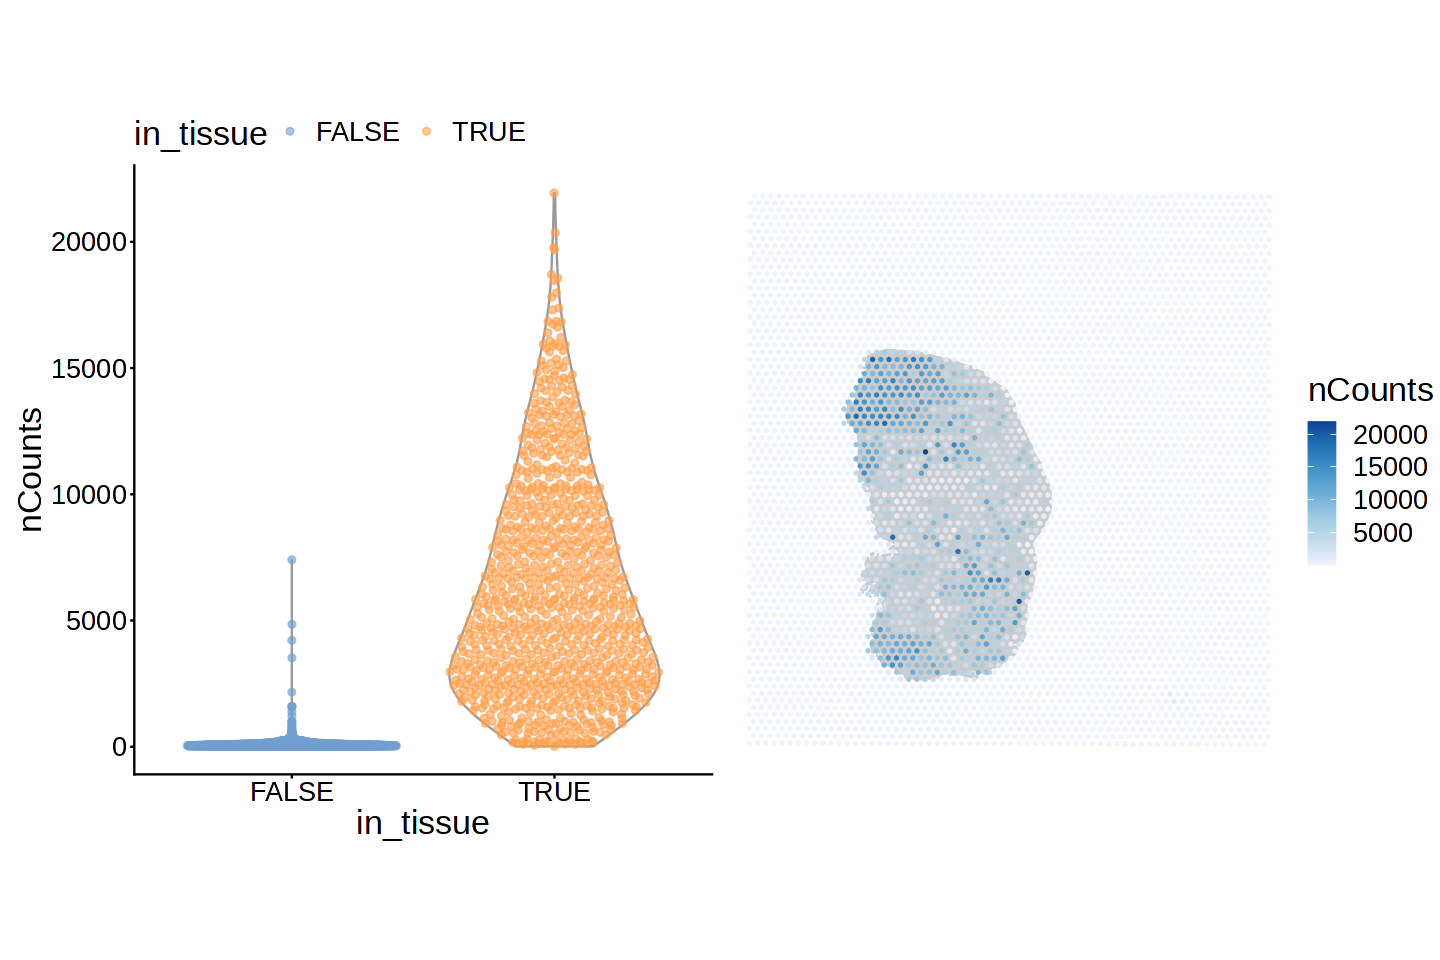

In [36]:
# colData(sfe)$nCounts <- colSums(counts(sfe))
plot_violin_spatial(sfe, "nCounts")

Some spots in the injury site with leukocyte infiltration have high total counts. Spatial autocorrelation of the total counts is apparent, which will be discussed in a later section of this vignette.

Next we find number of genes detected per spot. The commented out line of code shows how to find the number of genes detected.

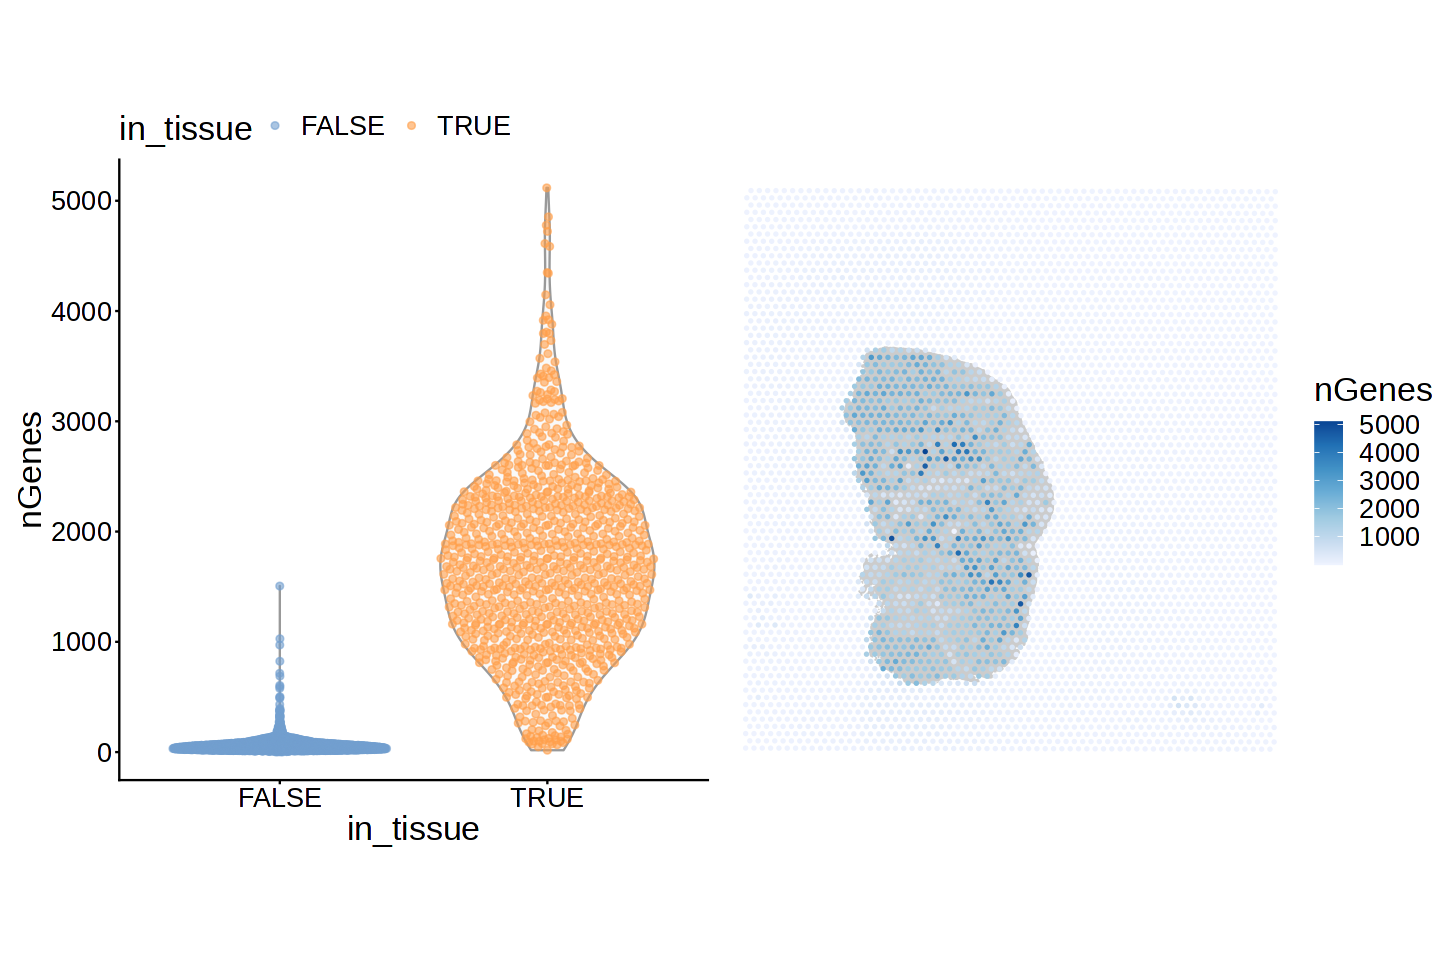

In [37]:
# colData(sfe)$nGenes <- colSums(counts(sfe) > 0)
plot_violin_spatial(sfe, "nGenes")

As commonly done for scRNA-seq data, here we plot nCounts vs. nGenes

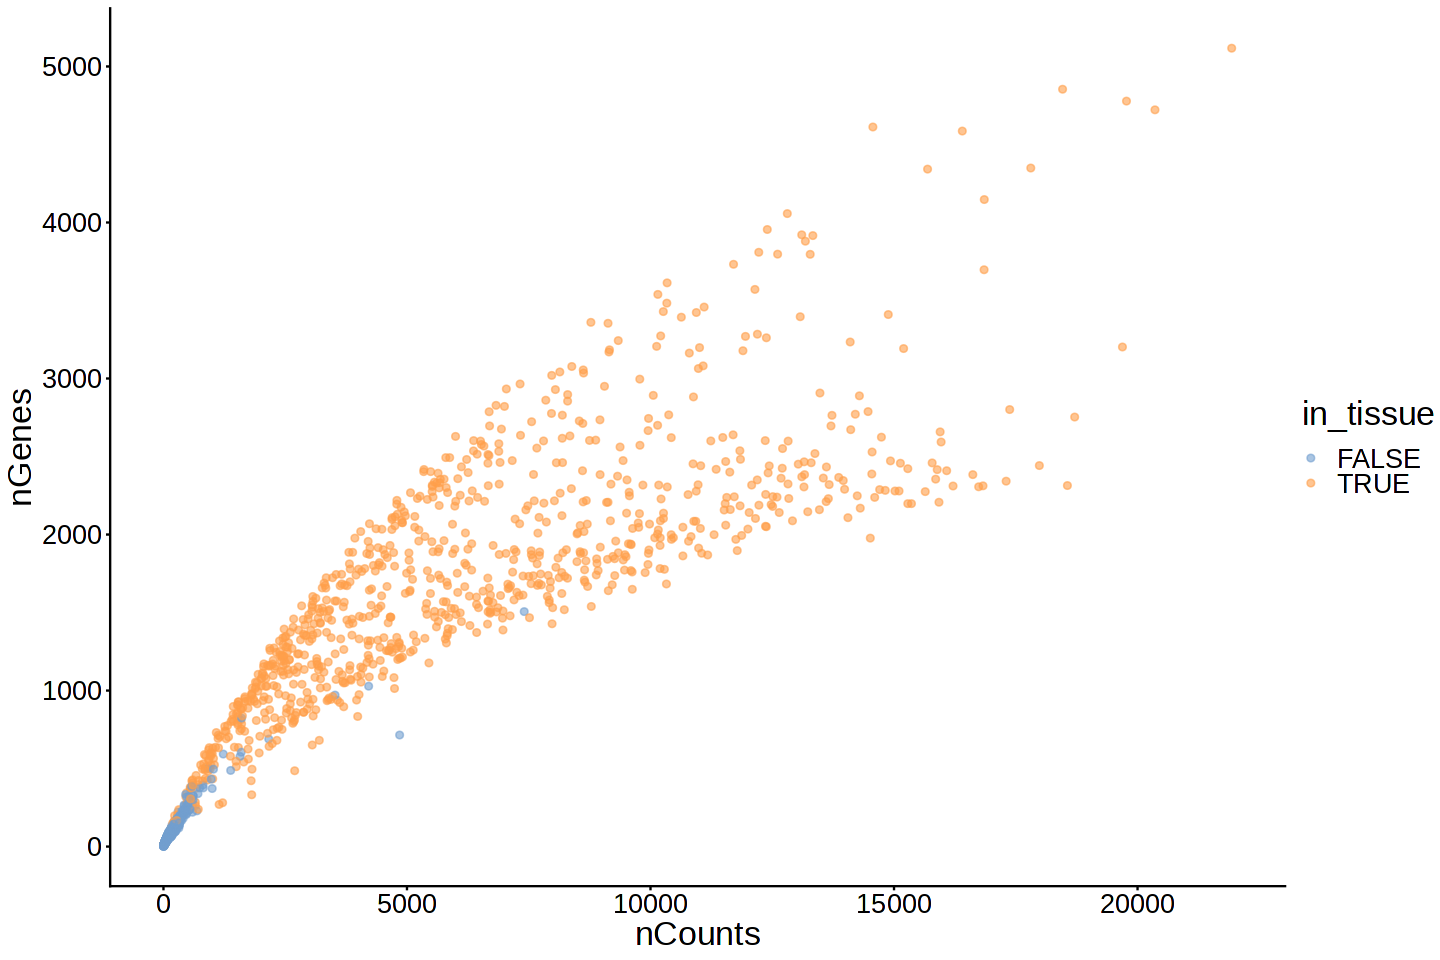

In [39]:
plotColData(sfe, x = "nCounts", y = "nGenes", colour_by = "in_tissue") +
  theme_font

This plot has two branches for the spots in tissue, which turn out to be related to myofiber size. See [the exploratory spatial data analysis (ESDA) Visium vignette](https://pachterlab.github.io/voyager/articles/vig2_visium.html).

As is commonly done for scRNA-seq data, we plot the proportion of mitochondrially encoded counts. The commented out code shows how to find this proportion:

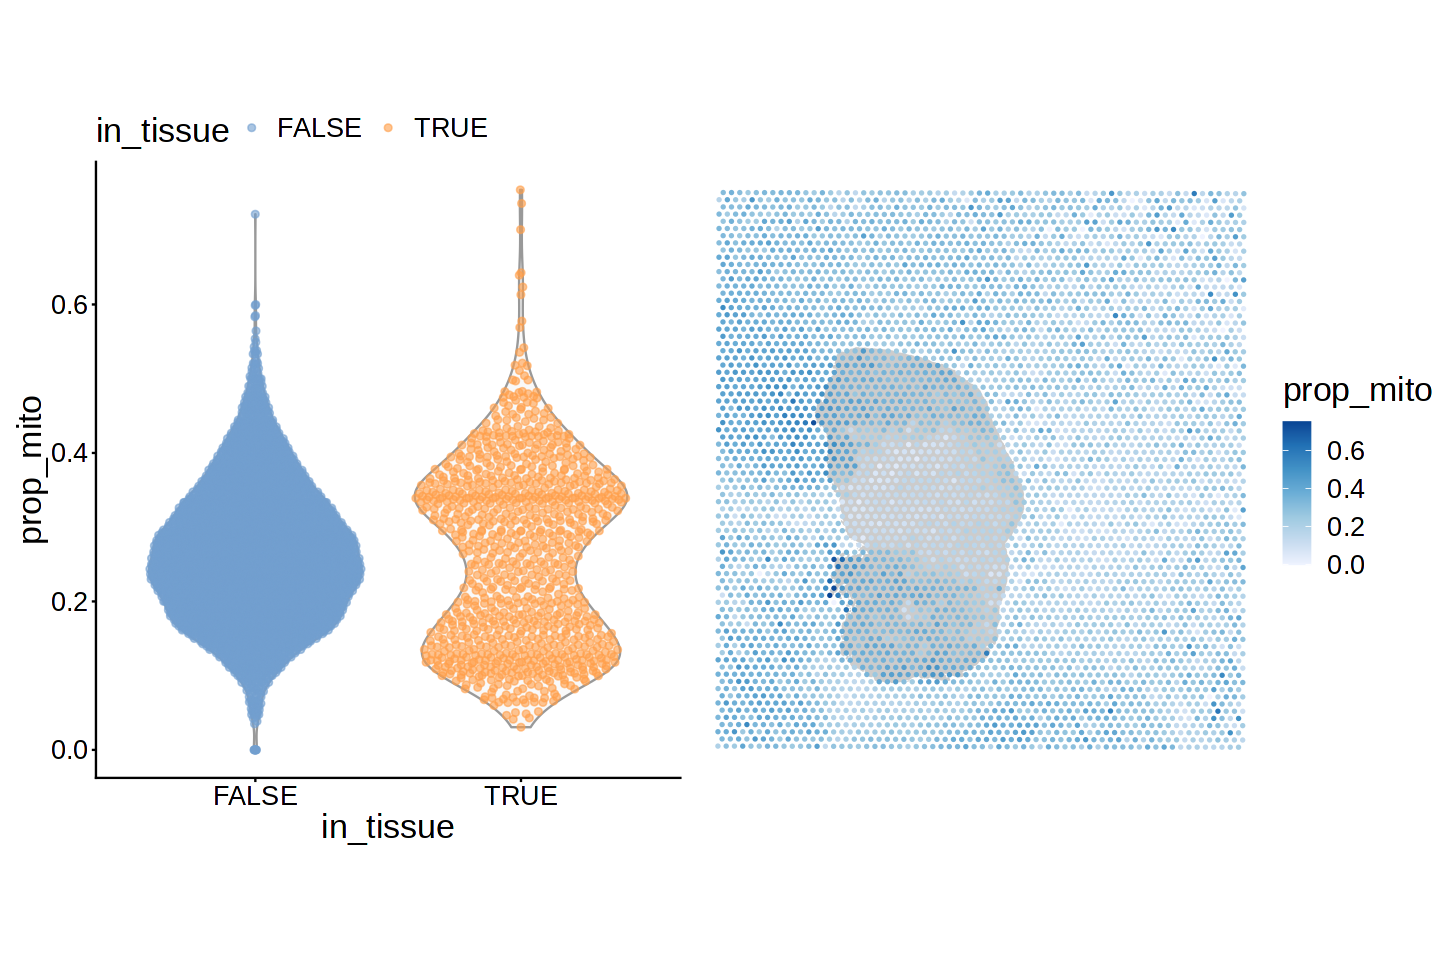

In [40]:
# mito_ind <- str_detect(rowData(sfe)$symbol, "^Mt-")
# colData(sfe)$prop_mito <- colSums(counts(sfe)[mito_ind,]) / colData(sfe)$nCounts
plot_violin_spatial(sfe, "prop_mito")

As expected, spots outside tissue have a higher proportion of mitochondrial counts, because when the tissue is lysed, mitochondrial transcripts are are less likely to degrade than cytosolic transcripts as they are protected by a double membrane. However, spots on myofibers also have a high proportion of mitochondrial counts, because of the function of myofibers. The injury site with leukocyte infiltration has a lower proportion of mitochondrial counts.

To see the relationship between the proportion of mitochondrial counts and total UMI counts,  we plot them against each other as is commonly done in scRNA-seq analysis to identify low quality cells, i.e. cells with few UMI counts and a high proportion of mitochondrial counts.

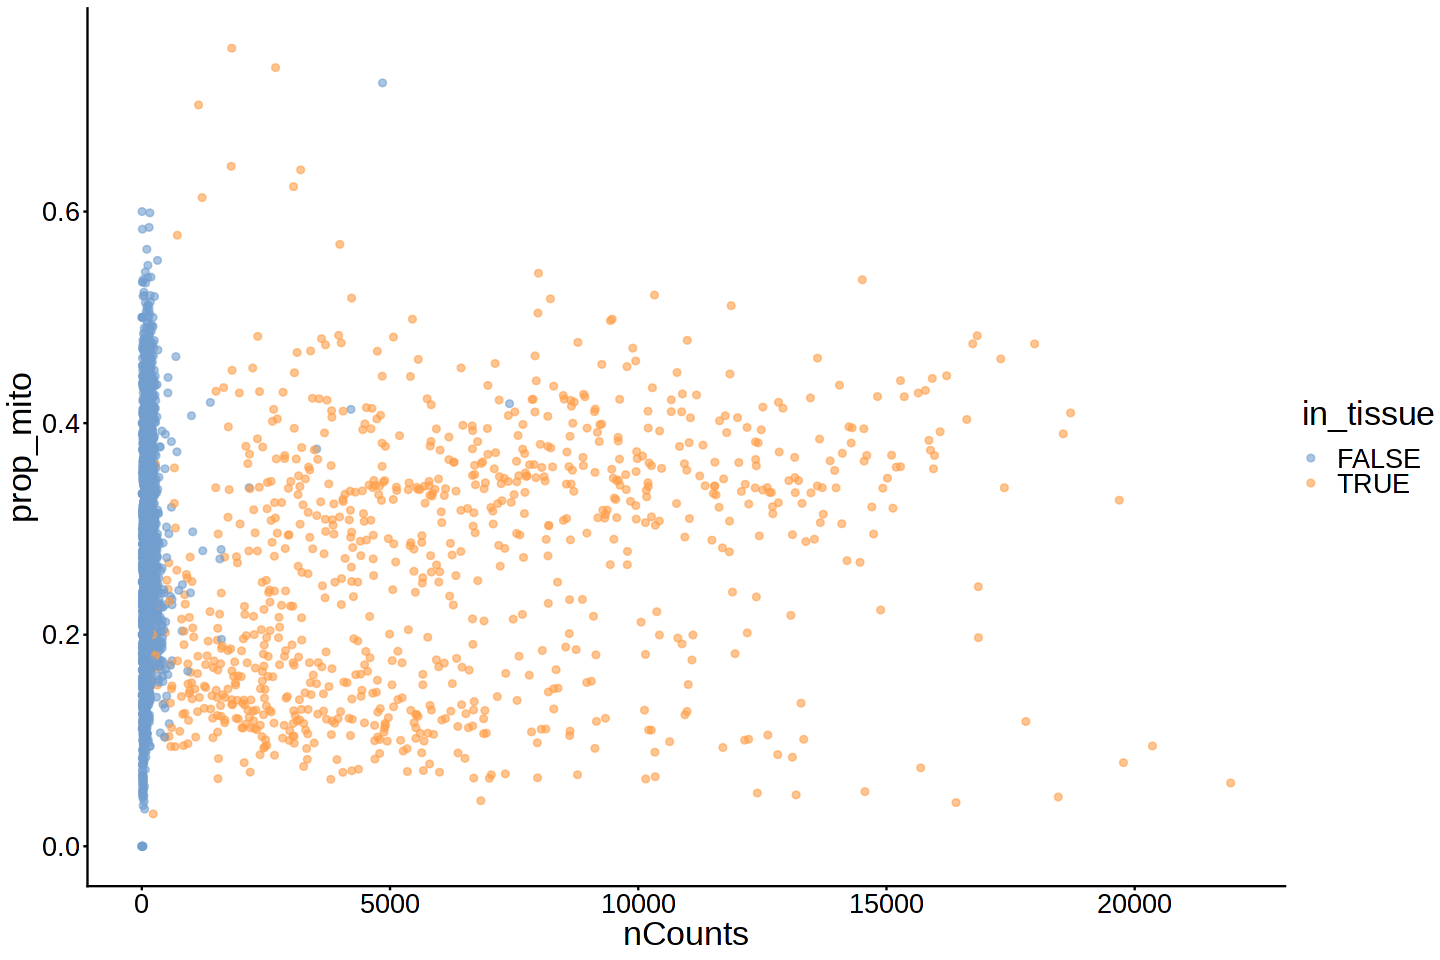

In [42]:
plotColData(sfe, x = "nCounts", y = "prop_mito", colour_by = "in_tissue") +
  theme_font

There are two clusters for the spots in tissue, which also turn out to be related to myofiber size. See the [ESDA Visium vignette](https://pachterlab.github.io/voyager/articles/vig2_visium.html). 

So far we haven't seen spots that are obvious outliers in these QC metrics.

The following analyses only use spots in tissue, which are selected as follows:

In [44]:
sfe_tissue <- sfe[, colData(sfe)$in_tissue]
sfe_tissue <- sfe_tissue[rowSums(counts(sfe_tissue)) > 0,]

## Genes
As in scRNA-seq, gene expression variance in Visium measurements is overdispersed compared to variance of counts that are Poisson distributed.

To understand the mean-variance relationship, we compute the mean, variance, and coefficient of variance (CV2) for each gene among spots in tissue:

In [45]:
rowData(sfe_tissue)$means <- rowMeans(counts(sfe_tissue))
rowData(sfe_tissue)$vars <- rowVars(counts(sfe_tissue))
# Coefficient of variance
rowData(sfe_tissue)$cv2 <- rowData(sfe_tissue)$vars/rowData(sfe_tissue)$means^2

To avoid overplotting and better show point density on the plot, we use a 2D histogram. The color of each bin indicates the number of points in that bin.

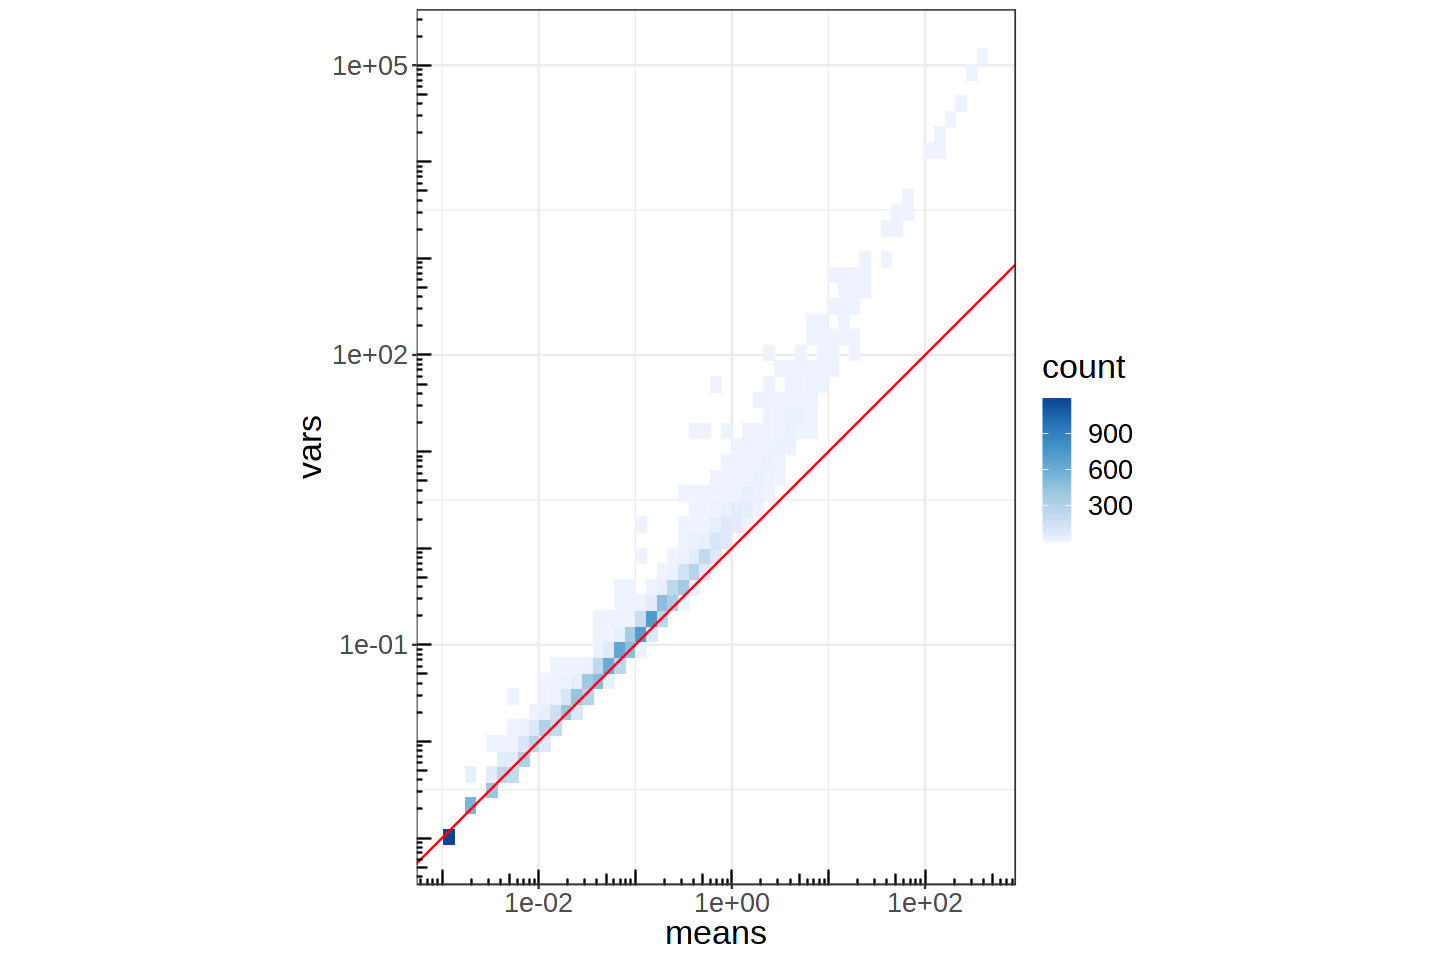

In [48]:
as.data.frame(rowData(sfe_tissue)) |> 
    ggplot(aes(means, vars)) +
    geom_bin2d(bins = 50) +
    geom_abline(slope = 1, intercept = 0, color = "red") +
    scale_x_log10() + scale_y_log10() +
    scale_fill_distiller(palette = "Blues", direction = 1) +
    annotation_logticks() +
    coord_equal()

The red line, $y = x$ is what is expected for Poisson distributed data, but we find that the variance is higher for more highly expressed genes than expected from Poisson distributed counts. The coefficient of variation shows the same.

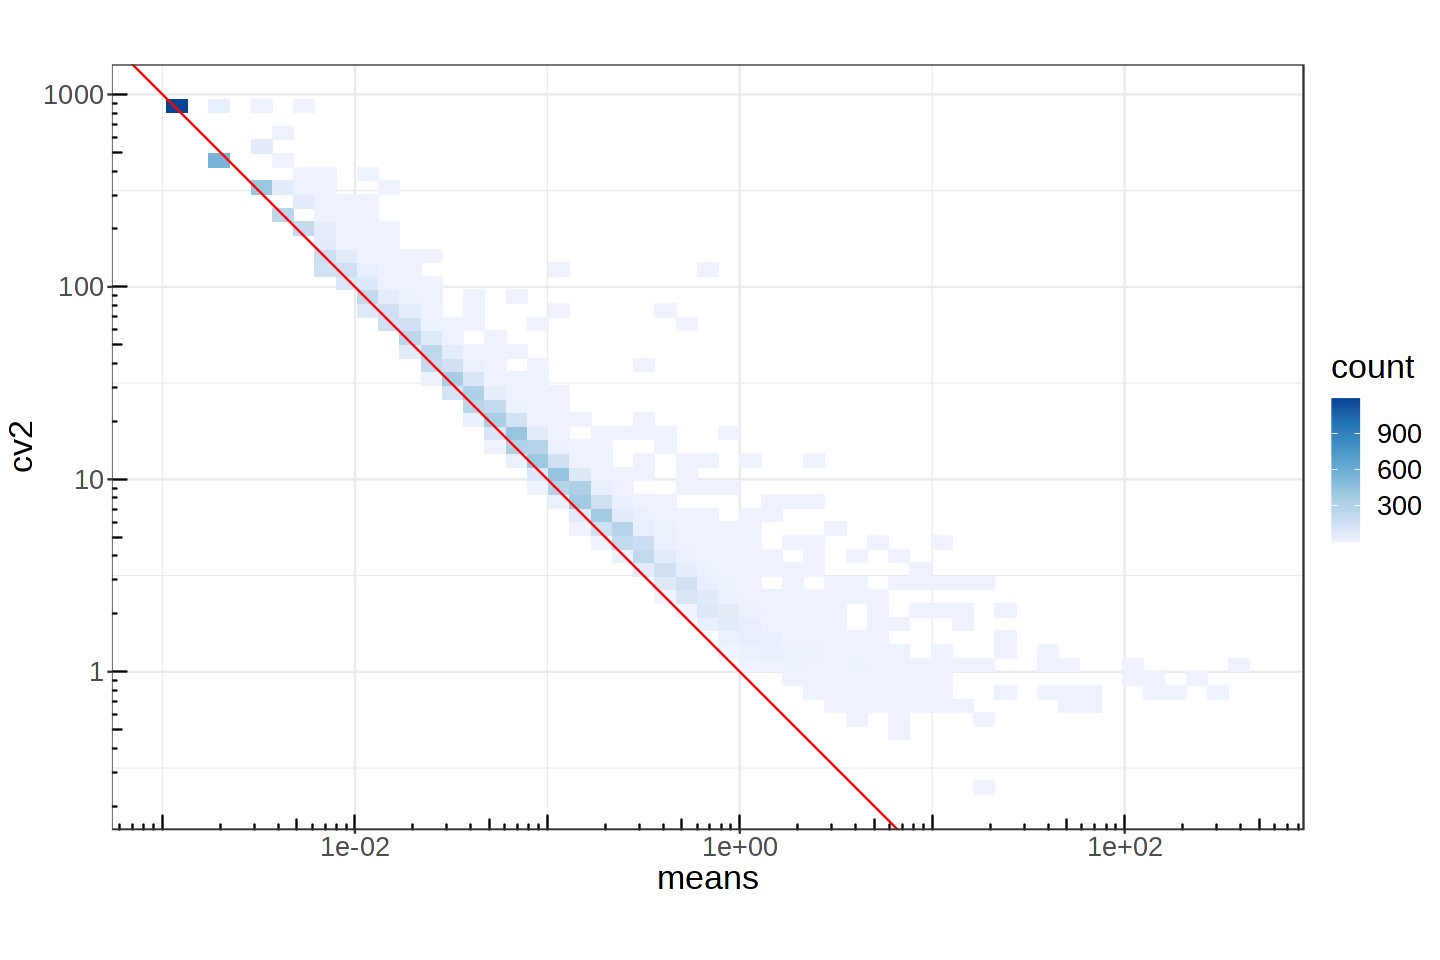

In [49]:
as.data.frame(rowData(sfe_tissue)) |> 
    ggplot(aes(means, cv2)) +
    geom_bin2d(bins = 50) +
    geom_abline(slope = -1, intercept = 0, color = "red") +
    scale_x_log10() + scale_y_log10() +
    scale_fill_distiller(palette = "Blues", direction = 1) +
    annotation_logticks() +
    coord_equal()

# Normalize data

We demonstrate the use of `scran` [@Lun2016-yq] for normalization below, although we note that it is not necessarily the best approach to normalizing spatial transcriptomics data. The problem of when and how to normalize spatial transcriptomics data is non-trivial because, as the `nCounts` plot in space shows above, spatial autocorrelation is evident. Furthemrore, in Visium, reverse transcription occurs in situ on the spots, but PCR amplification occurs after the cDNA is dissociated from the spots. Artifacts may be subsequently introduced from the amplification step, and these would not be associated with spatial origin. Spatial artifacts may arise from the diffusion of transcripts and tissue permeablization. However, given how the total counts seem to correspond to histological regions, the total counts may have a biological component and hence should not be treated as a technical artifact to be normalized away as in scRNA-seq data normalization methods. In other words, the issue of normalization for spatial transcriptomics data, and Visium in particular, is complex and is currently unsolved.

In [50]:
clusters <- quickCluster(sfe_tissue)
sfe_tissue <- computeSumFactors(sfe_tissue, clusters=clusters)
sfe_tissue <- sfe_tissue[, sizeFactors(sfe_tissue) > 0]
sfe_tissue <- logNormCounts(sfe_tissue)

Warning message in (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL) :
“encountered non-positive size factor estimates”


Next, we identify highly variable genes, which will be used for principal component analysis (PCA) dimensionality reduction.

In [51]:
dec <- modelGeneVar(sfe_tissue)
hvgs <- getTopHVGs(dec, n = 2000)

# Dimension reduction and clustering

In [52]:
sfe_tissue <- runPCA(sfe_tissue, ncomponents = 30, subset_row = hvgs,
                     scale = TRUE) # scale as in Seurat

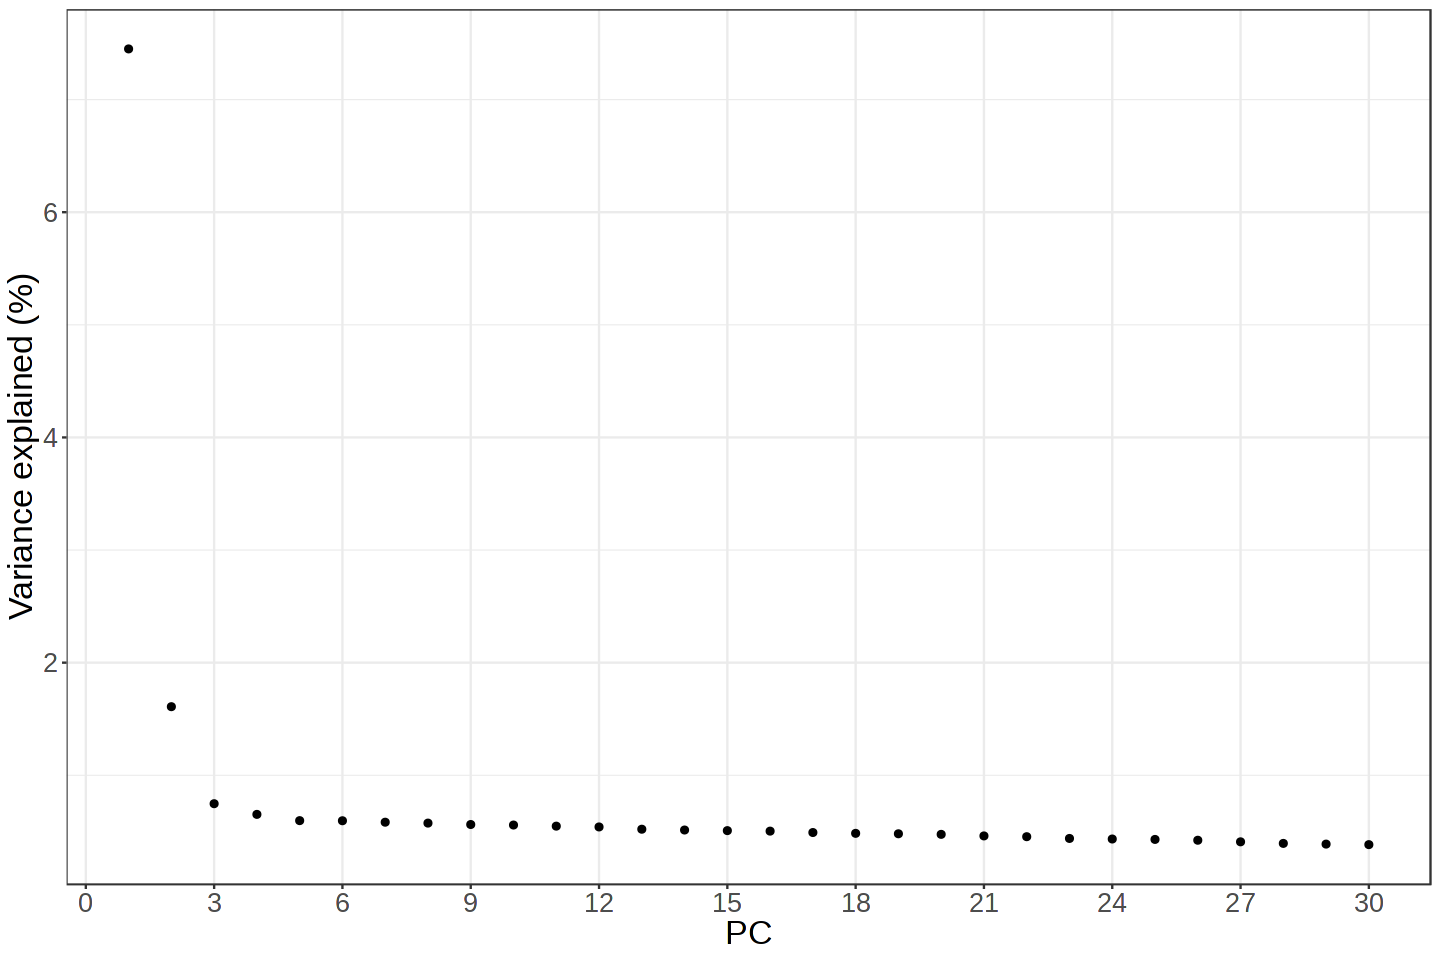

In [53]:
ElbowPlot(sfe_tissue, ndims = 30)

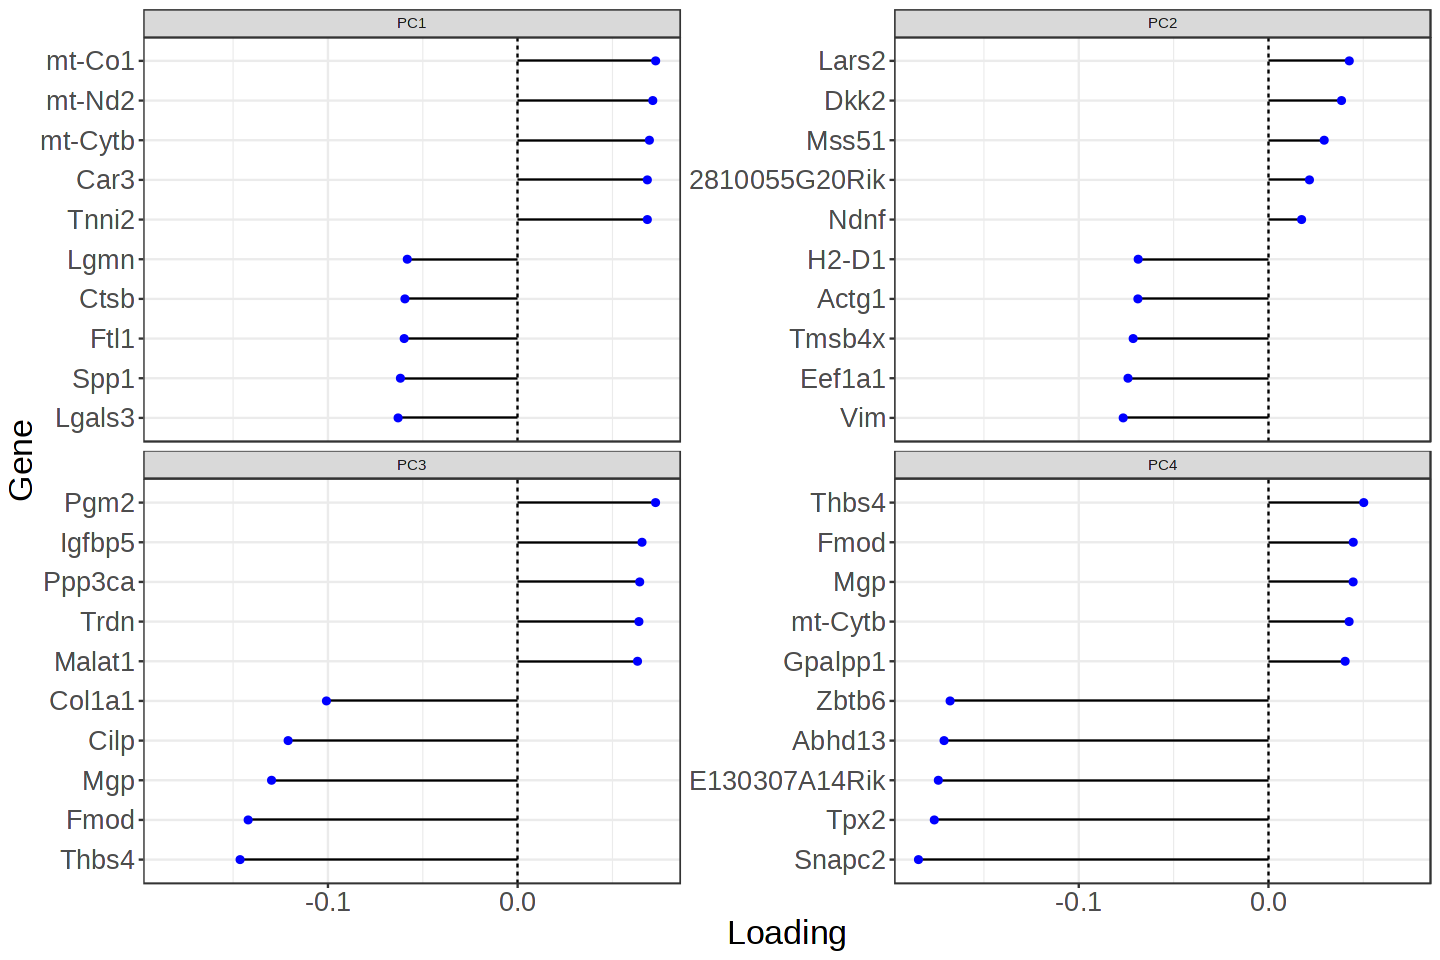

In [54]:
plotDimLoadings(sfe_tissue, dims = 1:4)

Do the clustering to show on the dimension reduction plots

In [55]:
colData(sfe_tissue)$cluster <- clusterRows(reducedDim(sfe_tissue, "PCA")[,1:3],
                                           BLUSPARAM = SNNGraphParam(
                                               cluster.fun = "leiden",
                                               cluster.args = list(
                                                   resolution_parameter = 0.5,
                                                   objective_function = "modularity")))

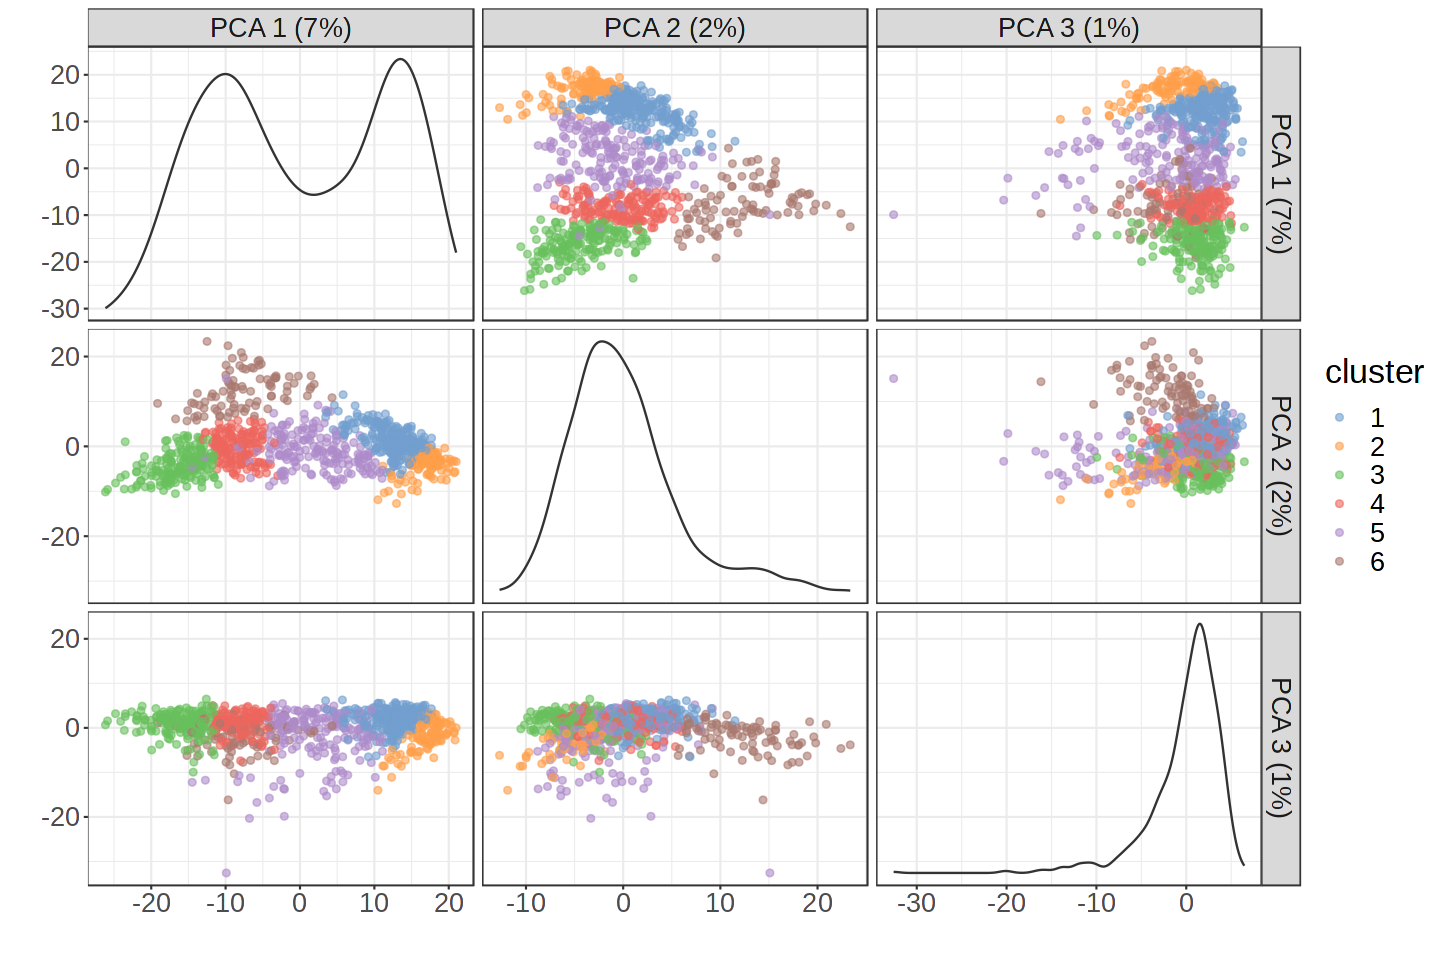

In [58]:
plotPCA(sfe_tissue, ncomponents = 3, colour_by = "cluster") + theme_font +
  theme(strip.text = element_text(size = 16))

The principal components (PCs) can be plotted in space. Due to spatial autocorrelation of many genes and spatial regions of different histological characters, even though spatial information is not used in the PCA procedure, the PCs may show spatial structure.

In [62]:
options(repr.plot.width=9, repr.plot.height=12)

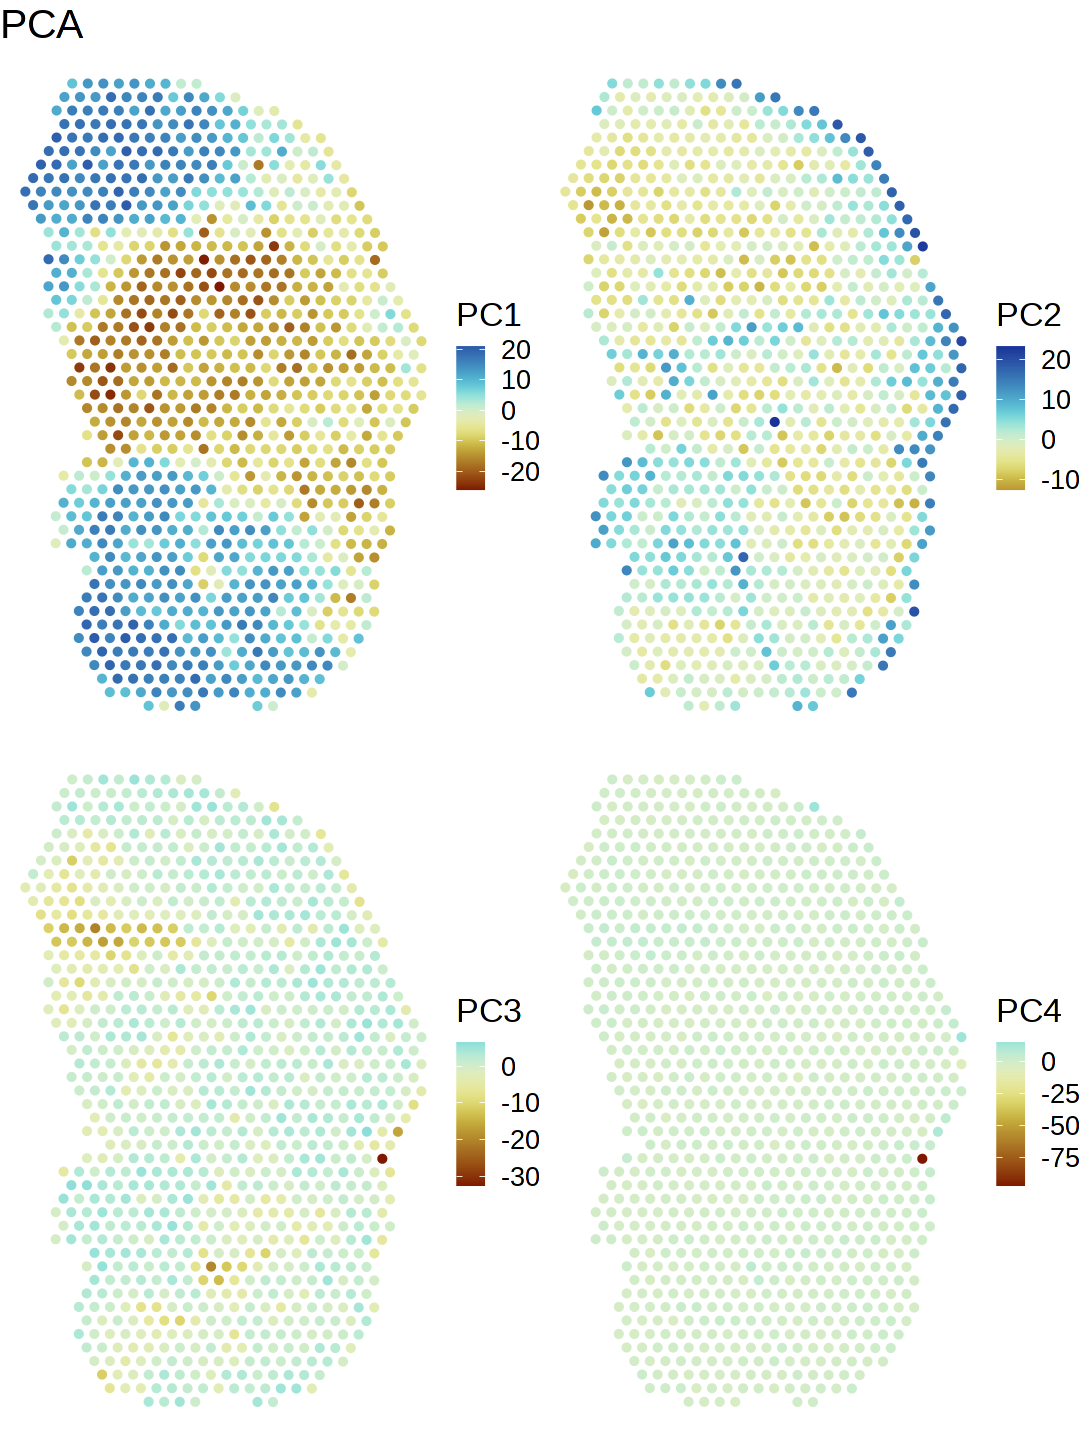

In [63]:
spatialReducedDim(sfe_tissue, "PCA", ncomponents = 4, 
                  colGeometryName = "spotPoly", divergent = TRUE, 
                  diverge_center = 0) &
    theme_void() & theme_font_void

In [67]:
options(repr.plot.width=12, repr.plot.height=8)

PC1, which explains far more variance than PC2, separates the injury site leukocytes and myofibers close to the site from the visium myofibers. PC2 highlight some myofibers near the edge. PC3 highlights the muscle tendon junctions. PC4 does not seem to be informative; it might have picked up an outlier.

It is also possible to run UMAP following the PCA, as is done for scRNA-seq. We do not recommend producing a UMAP since the procedure distorts distances, and does not respect either local or global structure in the data [@Chari2021-hb]. However, for completeness, we show how to compute a UMAP below:

In [65]:
set.seed(29)
sfe_tissue <- runUMAP(sfe_tissue, dimred = "PCA", n_dimred = 3)

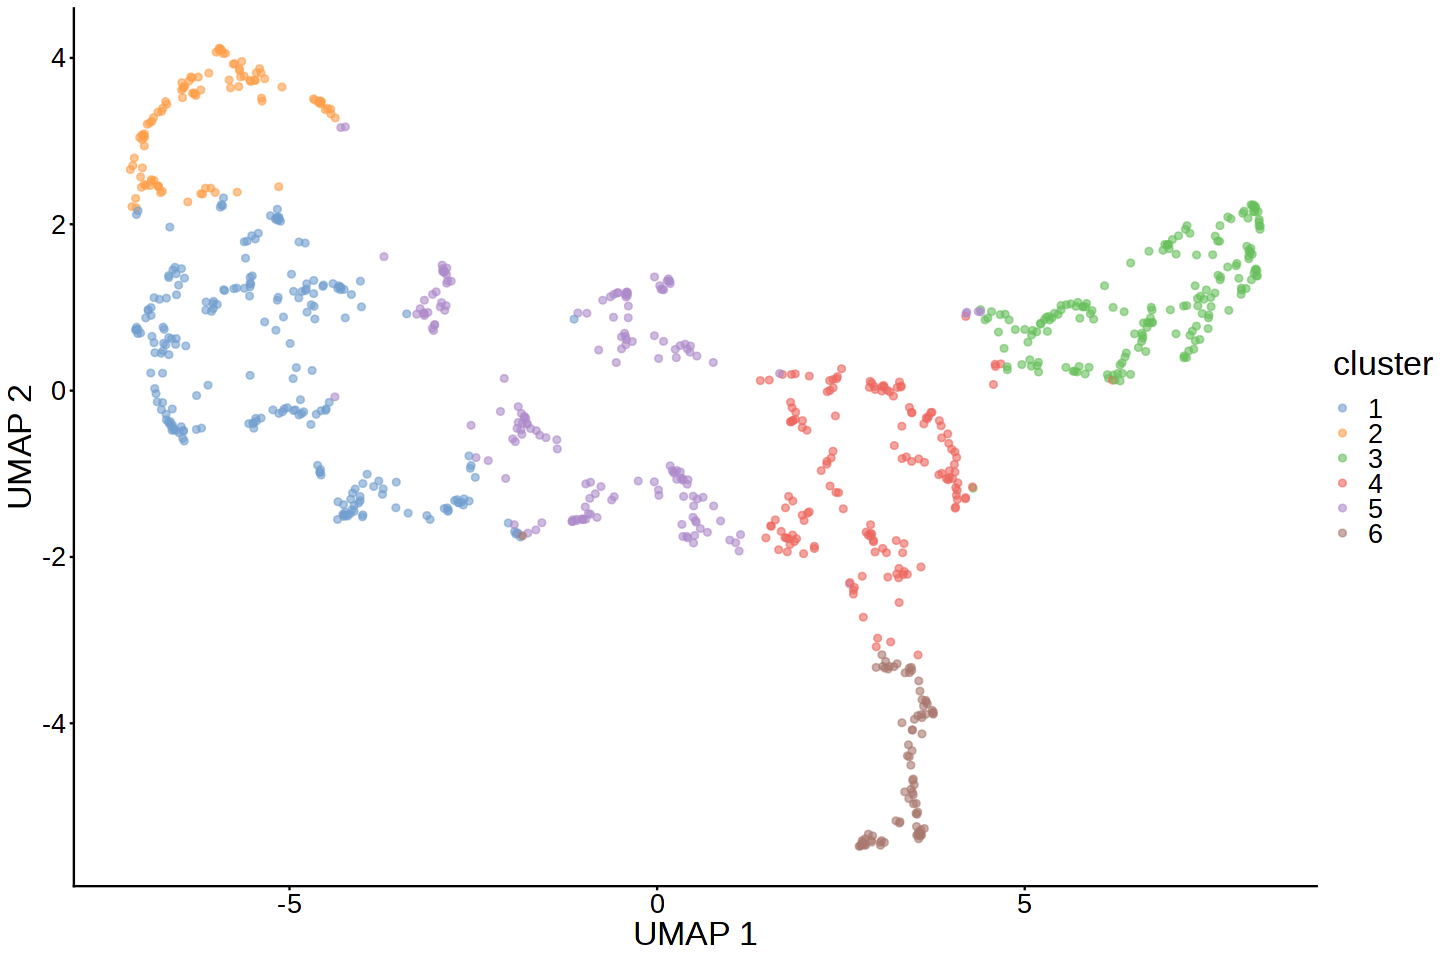

In [68]:
plotUMAP(sfe_tissue, colour_by = "cluster") + theme_font

More interesting in spatial transcriptomics, is to locate the clusters in space, and this can be done as follows:

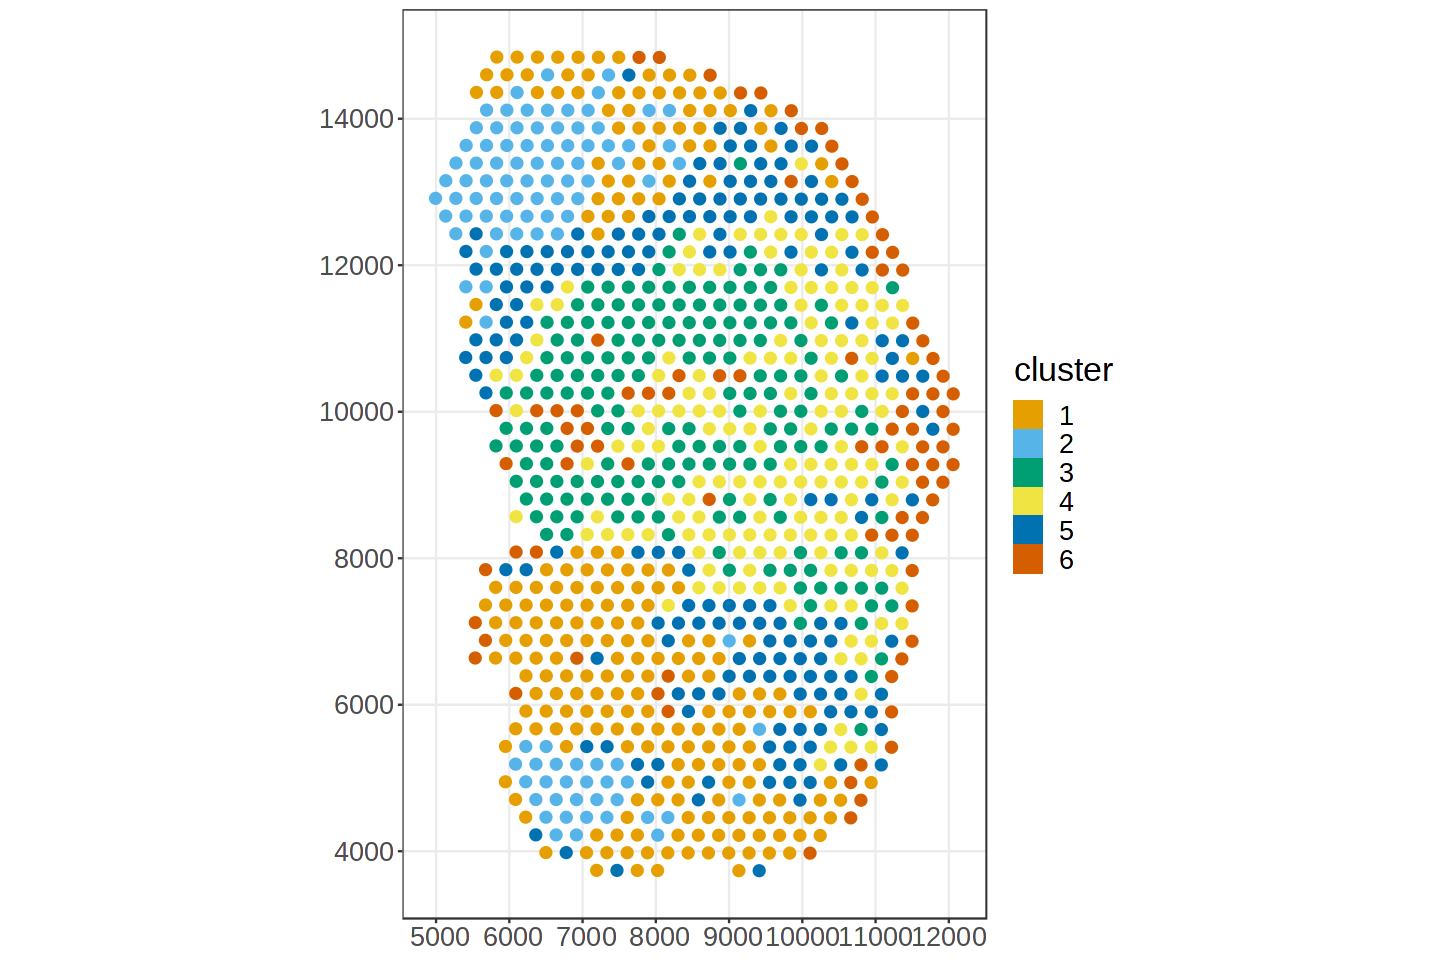

In [69]:
plotSpatialFeature(sfe_tissue, "cluster", colGeometryName = "spotPoly")

While spatial information is not explicitly used in clustering, due to spatial autocorrelation of gene expression and the histological regions, some of these clusters are spatially contiguous. There are many methods to find spatially informed clusters, such as [`BayesSpace`](https://bioconductor.org/packages/release/bioc/html/BayesSpace.html) [@Zhao2021-vb], which is on Bioconductor.

Remark on spatial regions: In geographical space, there is usually no one single way to define spatial regions. For example, influenced by both sociology and geology, LA county can be partitioned into regions such as Eastside, Westside, South Central, San Fernado Valley, San Gabriel Valley, Pomona Valley, Gateway Cities, South Bay, and etc., each containing multiple smaller cities or parts of LA City, each of which can be further divided into many neighborhoods, such as Koreatown, Highland Park, Lincoln Heights, and etc. Definitions of some of these regions are subject to dispute. Meanwhile, LA county can also be partitioned into watersheds of the LA River, San Gabriel River, Ballona Creek, and etc., as well as different rock formations. Which kind of spatial region at which resolution is relevant depends on the question being asked. There are also gray areas in spatial regions. For example, the Whittier Narrows dam intercepts both the San Gabriel River and Rio Hondo (a large tributary of the LA River), so whether the dam area belongs to the watershed of San Gabriel River or LA River is unclear. 

Similarly, in spatial transcriptomics, while methods identifying spatial regions currently generally only aim to give one result, multiple results at different resolutions depending on the question asked may be relevant. Furthermore, methods for spatial region demarcation to be used for spatial -omics would ideally provide uncertainty assessments for assignment of cells or Visium spots. An existing geospatial method that accounts for such uncertainty is [`geocmeans`](https://cran.r-project.org/web/packages/geocmeans/) [@Zhao2013-tw], which is on CRAN.

In both the geographical and histological space, there conflicting views on spatial variation. On the one hand, methods that identify spatially variable genes such as SpatialDE often assume that gene expression vary smoothly and continuously in space. On the other hand, methods identifying spatial regions attempt to identify discrete regions. The continuous variation in features might be why definitions of geographical neighborhoods are often subject to dispute. Some existing methods attempt to harmonize the two views. For example, the spatially variable gene method [`belayer`](https://github.com/raphael-group/belayer) [@Ma2022-dc] takes discrete tissue layers into account.

# Non-spatial differential expression
Cluster marker genes can be found using differential analysis methods as is commonly done for scRNA-seq. Below is an example with the Wilcoxon rank sum test:

In [70]:
markers <- findMarkers(sfe_tissue, groups = colData(sfe_tissue)$cluster,
                       test.type = "wilcox", pval.type = "all", direction = "up")

The result is sorted by p-values:

In [71]:
markers[[6]]

DataFrame with 15043 rows and 8 columns
                       p.value         FDR summary.AUC     AUC.1     AUC.2
                     <numeric>   <numeric>   <numeric> <numeric> <numeric>
ENSMUSG00000098178 6.38946e-11 9.61167e-07    0.732096  0.732096  0.877065
ENSMUSG00000028031 6.09748e-02 1.00000e+00    0.524655  0.539008  0.544944
ENSMUSG00000041052 1.11863e-01 1.00000e+00    0.508443  0.511236  0.511236
ENSMUSG00000044349 1.44561e-01 1.00000e+00    0.505618  0.505618  0.505618
ENSMUSG00000095676 1.44561e-01 1.00000e+00    0.505618  0.505618  0.505618
...                        ...         ...         ...       ...       ...
ENSMUSG00000087095           1           1         0.5       0.5  0.495098
ENSMUSG00000043969           1           1         0.5       0.5  0.500000
ENSMUSG00000091378           1           1         0.5       0.5  0.500000
ENSMUSG00000072437           1           1         0.5       0.5  0.500000
ENSMUSG00000094649           1           1         0.5      

Significant markers for each cluster can be obtained as follows:

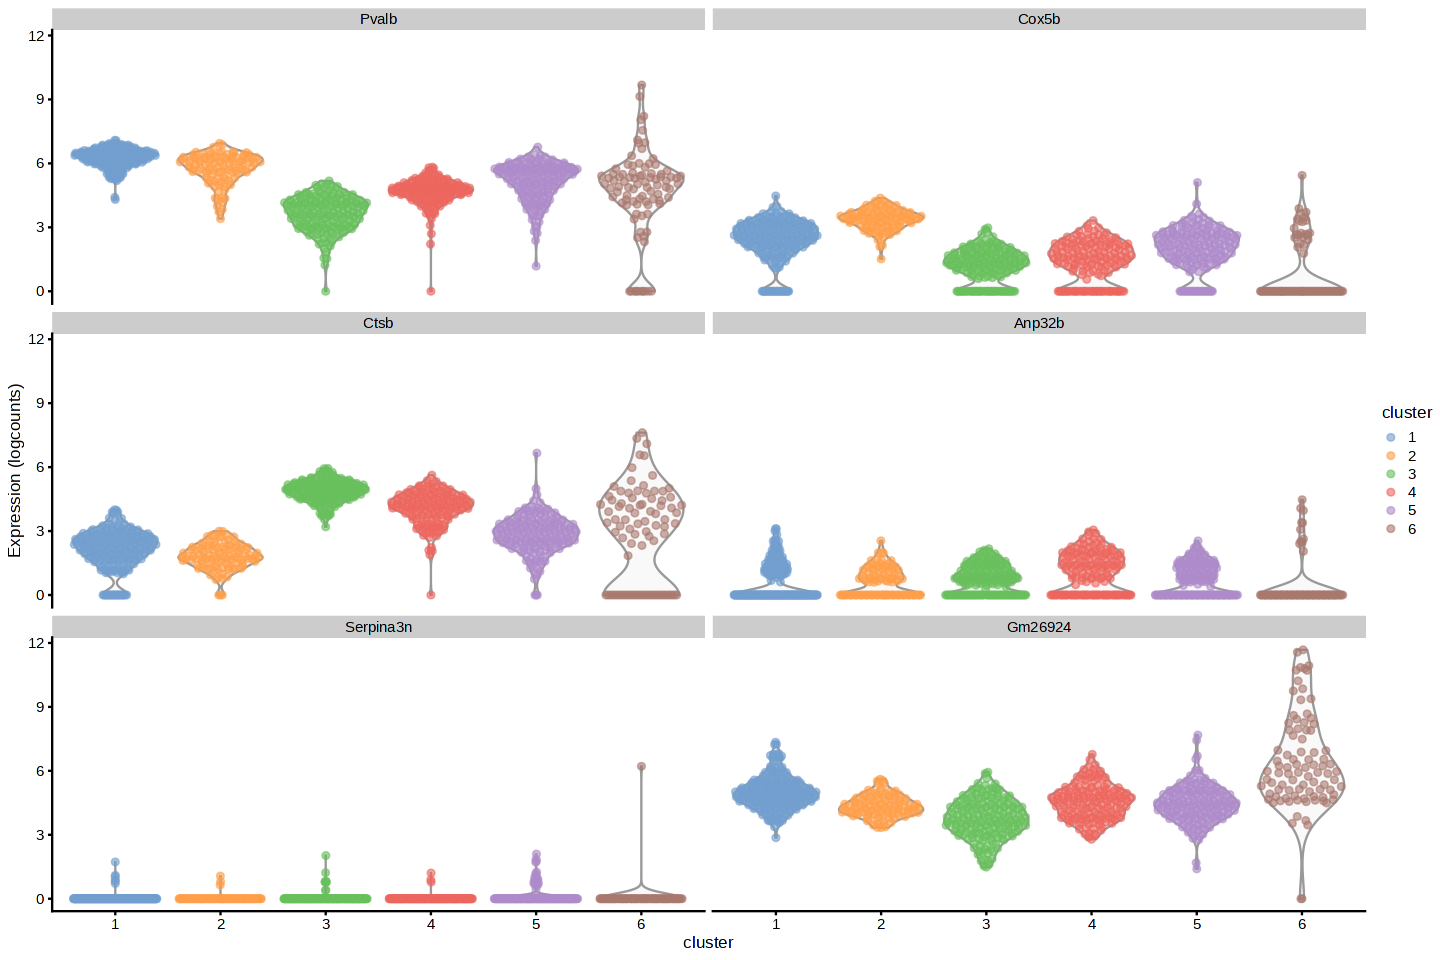

In [72]:
genes_use <- vapply(markers, function(x) rownames(x)[1], FUN.VALUE = character(1))
plotExpression(sfe_tissue, rowData(sfe_tissue)[genes_use, "symbol"], x = "cluster",
               colour_by = "cluster", swap_rownames = "symbol")

These genes are interesting to view in spatial context:

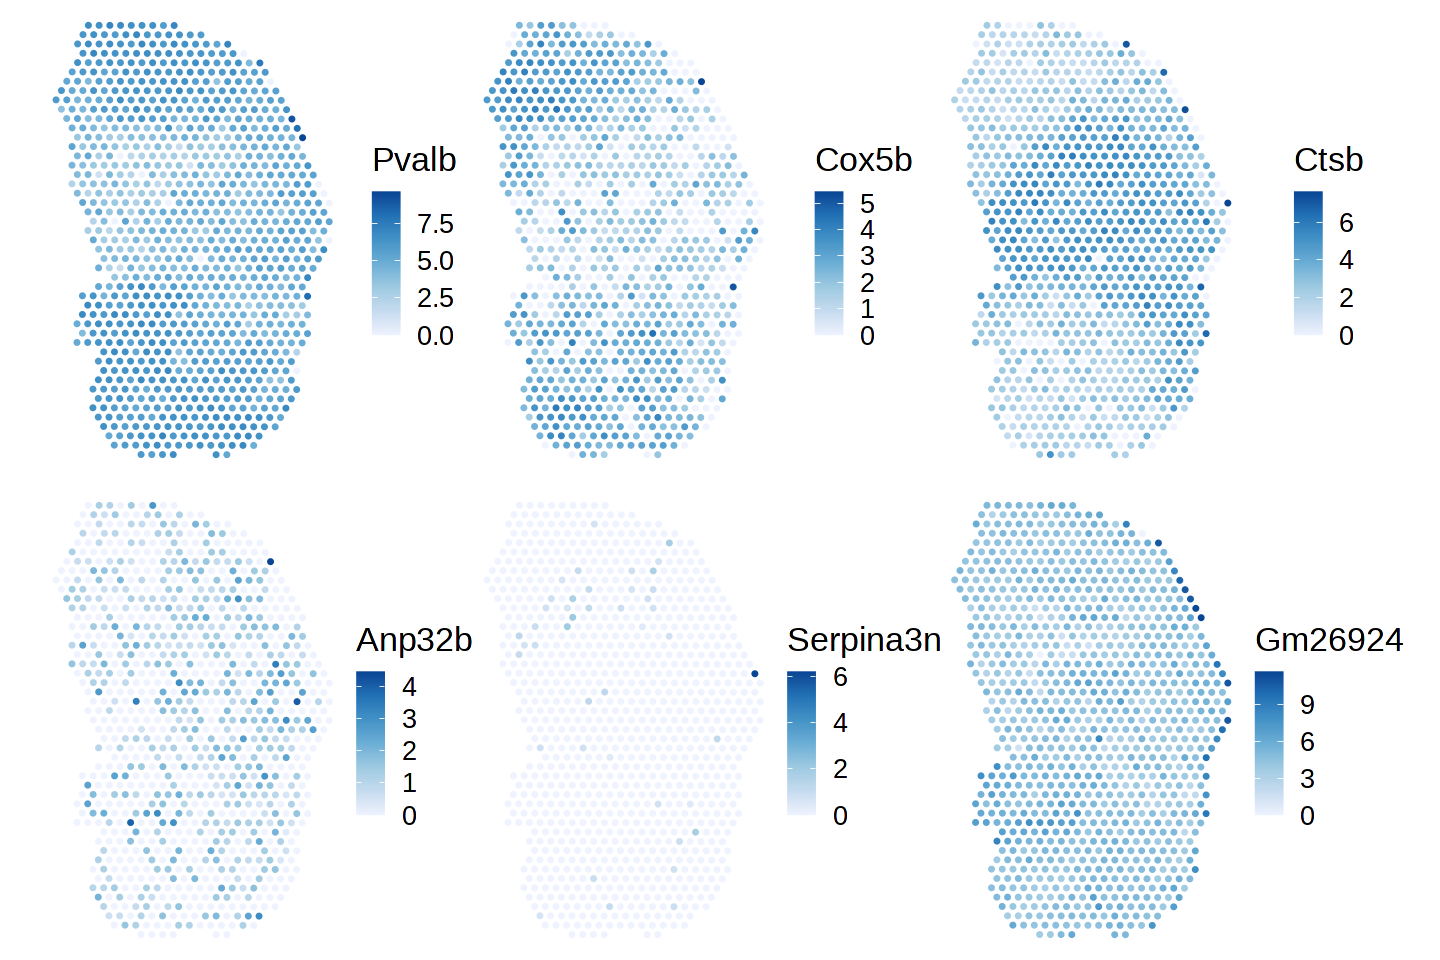

In [73]:
plotSpatialFeature(sfe_tissue, genes_use, colGeometryName = "spotPoly") &
    theme_void() & theme_font_void

# Moran's I
Tobler's first law of geography states that

> Everything is related to everything else. But near things are more related than distant things.

This observation motivates the examination of spatial autocorrelation. Positive spatial autocorrelation is evident when nearby things tend to be similar, such as that weather in Pasadena and downtown Los Angeles (as opposed to the weather in Pasadena and San Francisco). Negative spatial autocorrelation is evident when nearby things tend to be more dissimilar, like squares on a chessboard. Spatial autocorrelation can be arise from an intrinsic process such as diffusion or communication by physical contact, or result from a covariate that has such an intrinsic process, or in areal data, when the areal units of observation are smaller than the scale of the spatial process.

The most commonly used measure of spatial autocorrelation is Moran's I, defined as

$$
I = \frac{n}{\sum_{i=1}^n \sum_{j=1}^n w_{ij}} \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^n (x_i - \bar{x})^2},
$$

where $n$ is the number of spots or locations, $i$ and $j$ are different locations, or spots in the Visium context, $x$ is a variable with values at each location, and $w_{ij}$ is a spatial weight, which can be inversely proportional to distance between spots or an indicator of whether two spots are neighbors, subject to various definitions of neighborhood and whether to normalize the number of neighbors. The [`spdep`](https://r-spatial.github.io/spdep/index.html) package uses the neighborhood. 

Moran's I is similar to the Pearson correlation between the value at each location and the average value at its neighbors (but not identical, see [@Lee2001-tm]). Just like Pearson correlation, Moran's I is generally bound between -1 and 1, where positive value indicates positive spatial autocorrelation and negative value indicates negative spatial autocorrelation. 
Spatial dependence analysis in `spdep` requires a spatial neighborhood graph. The graph for adjacent Visium spot can be found with

In [74]:
colGraph(sfe_tissue, "visium") <- findVisiumGraph(sfe_tissue)

We mentioned that spatial autocorrelation is apparent in total UMI counts. Here's what Moran's I shows:

In [75]:
calculateMoransI(t(colData(sfe_tissue)[,c("nCounts", "nGenes")]), 
                 listw = colGraph(sfe_tissue, "visium"))

DataFrame with 2 rows and 2 columns
            moran         K
        <numeric> <numeric>
nCounts  0.528705   3.00082
nGenes   0.384028   3.88036

K means kurtosis. The positive values of Moran's I indicate positive spatial autocorrelation.

## Spatially variable genes
A spatially variable gene is a gene whose expression depends on spatial locations, rather than being spatially random, like salt grains spread on a soup. Spatially variable genes can be identified by spatial autocorrelation signatures, and sometimes Moran's I is used to compare and assess spatially variable genes identified with different methods. Below `BPPARAM` is used to parallelize the computation of Moran's I for 2000 highly variable genes, and 2 cores are used with the SNOW backend.

In [76]:
sfe_tissue <- runMoransI(sfe_tissue, features = hvgs, colGraphName = "visium",
                         BPPARAM = SnowParam(2))

Warning message:
“<anonymous>: ... may be used in an incorrect context: ‘fun(x[i, ], listw, ...)’
”


That warning only occurs with `SnowParam`, but not with other backends, and does not affect the results. The results are stored in `rowData`

In [77]:
rowData(sfe_tissue)

DataFrame with 15043 rows and 8 columns
                              Ensembl      symbol            type      means
                          <character> <character>     <character>  <numeric>
ENSMUSG00000025902 ENSMUSG00000025902       Sox17 Gene Expression 0.03969957
ENSMUSG00000096126 ENSMUSG00000096126     Gm22307 Gene Expression 0.00107296
ENSMUSG00000033845 ENSMUSG00000033845      Mrpl15 Gene Expression 0.38197425
ENSMUSG00000025903 ENSMUSG00000025903      Lypla1 Gene Expression 0.28755365
ENSMUSG00000033813 ENSMUSG00000033813       Tcea1 Gene Expression 0.26502146
...                               ...         ...             ...        ...
ENSMUSG00000064360 ENSMUSG00000064360      mt-Nd3 Gene Expression  56.445279
ENSMUSG00000064363 ENSMUSG00000064363      mt-Nd4 Gene Expression 123.991416
ENSMUSG00000064367 ENSMUSG00000064367      mt-Nd5 Gene Expression  14.645923
ENSMUSG00000064368 ENSMUSG00000064368      mt-Nd6 Gene Expression   0.109442
ENSMUSG00000064370 ENSMUSG0000006437

The `NA`'s are for genes that are not highly variable and Moran's I was not computed for those genes. We rank the genes by Moran's I and plot them in space as follows:

In [78]:
df <- rowData(sfe_tissue)[hvgs,]
ord <- order(df$moran_Vis5A, decreasing = TRUE)
df[ord, c("symbol", "moran_Vis5A")]

DataFrame with 2000 rows and 2 columns
                        symbol moran_Vis5A
                   <character>   <numeric>
ENSMUSG00000064351      mt-Co1    0.814980
ENSMUSG00000064345      mt-Nd2    0.784339
ENSMUSG00000018893          Mb    0.761522
ENSMUSG00000056328        Myh1    0.727282
ENSMUSG00000064370     mt-Cytb    0.722350
...                        ...         ...
ENSMUSG00000055436      Srsf11  -0.0397929
ENSMUSG00000067713      Prkag1  -0.0404949
ENSMUSG00000090262       Mpv17  -0.0423579
ENSMUSG00000030061        Uba3  -0.0424449
ENSMUSG00000020964       Sel1l  -0.0507095

We see that some genes that have strong positive spatial autocorrelation, but don't observe strong negative spatial autocorrelation. We can plot the genes with the strongest positive spatial autocorrelation in space:

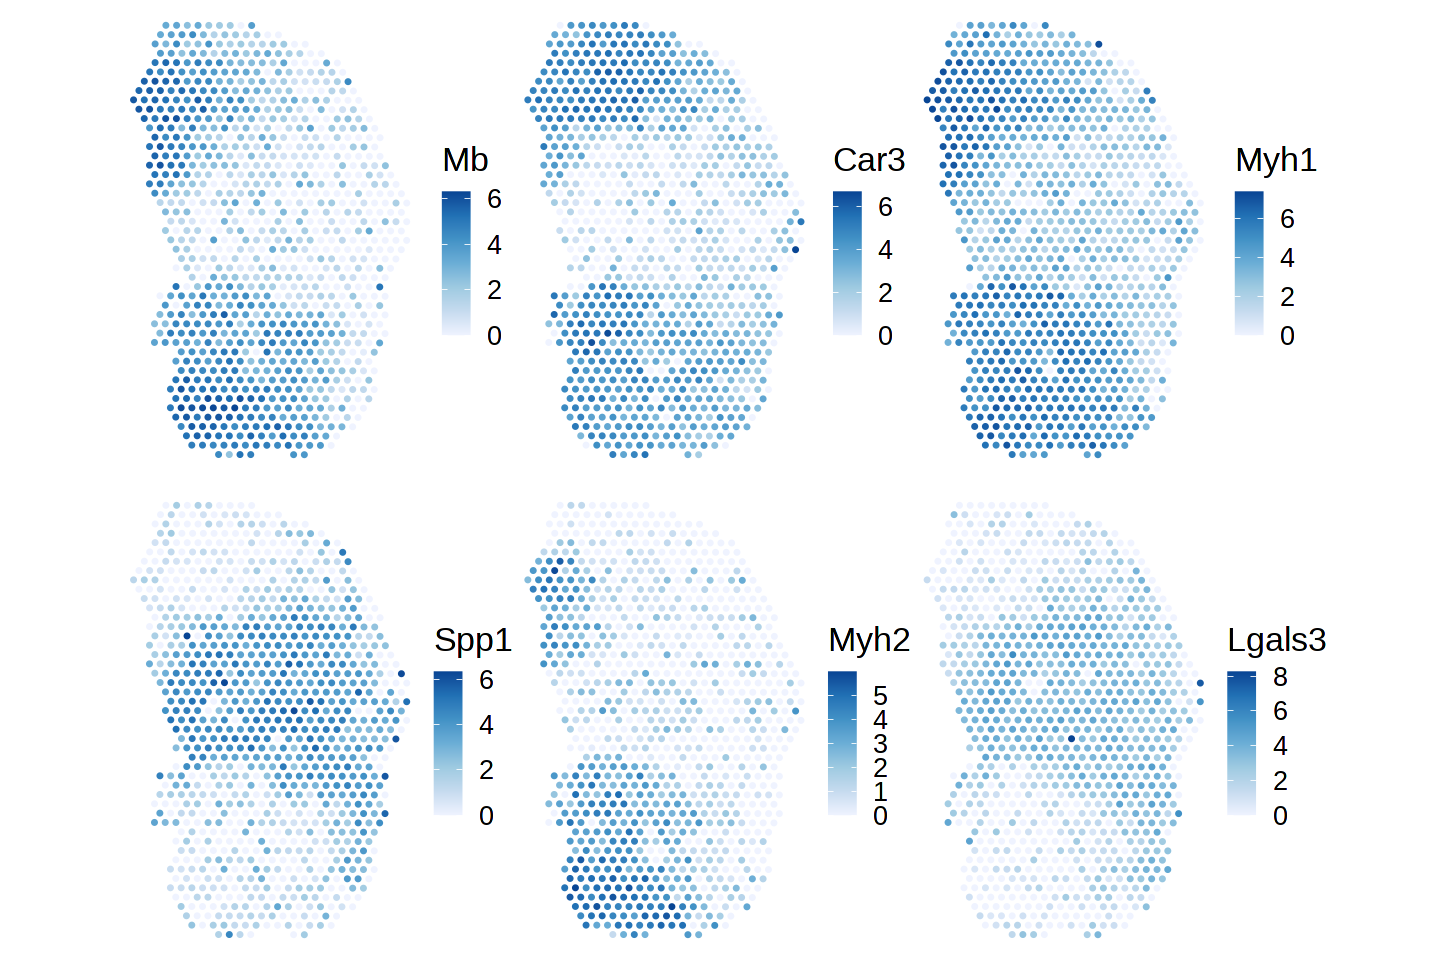

In [80]:
plotSpatialFeature(sfe_tissue, rownames(df)[1:6], colGeometryName = "spotPoly") &
    theme_void() + theme_font_void

These genes do indeed look spatially variable. However, such spatial variability can simply be due to the histological regions in space, or in other words, spatial distribution of different cell types. There are many methods to identify spatially variable genes, often involving Gaussian process modeling, which are far more complex than Moran's I, such as [`SpatialDE`](https://bioconductor.org/packages/release/bioc/html/spatialDE.html) [@Svensson2018-sx]. However, such methods usually don't account for the histological regions, except for `C-SIDE` [@Cable2022-ma], which identifies spatially variable genes within cell types. This leads to the question of what is really meant by "cell type". It remains to see how spatial methods made specifically for identifying spatially variable genes compare with methods that don't explicitly use spatial information but simply perform differential analysis between cell types which often are in spatially defined histological regions. 

Another consideration in using Moran's I is the extent to which the strength of spatial autocorrelation varies in space. What if a gene exhibits strong spatial autocorrelation in one region, but not in another? Should the different histological regions be analyzed separately in some cases? 

There are ways to see whether Moran's I is statistically significant, and many other methods to explore spatial autocorrelation. These are discussed in the more advanced [ESDA Visium vignette](https://pachterlab.github.io/voyager/articles/vig2_visium.html). 

# Session Info

In [81]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] sparseMatrixStats_1.9.0          stringr_1.4.1                   
 [3] BiocParallel_1.31.15             SFEData_0.99.7                  
 [5] bluster_1.7.0                    patchwork_1.1.2                 
 [7] scran_1.25.1                     scate

# References